# Gesture Recognition Using TensorFlow

## Problem Statement

Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote. Let's have professor Raghavan introduce you to the problem statement:

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

- Thumbs up:  Increase the volume
- Thumbs down: Decrease the volume
- Left swipe: 'Jump' backwards 10 seconds
- Right swipe: 'Jump' forward 10 seconds  
- Stop: Pause the movie

# Checking GPU

In [1]:
import platform
import tensorflow as tf

print("Python version: ", platform.python_version())
print("TensorFlow version: ", tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU not found. Running on CPU.')
else:
    print('GPU found. Running on GPU.')

Python version:  3.10.12
TensorFlow version:  2.12.0
GPU found. Running on GPU.


In [2]:
!pip install imageio

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**We set the random seed so that the results don't vary drastically.**
setting up a Python environment for deep learning using libraries like NumPy, TensorFlow, and Keras. Here's a breakdown of what this code does:

1. **Importing Libraries**: You import necessary libraries for numerical computation (`numpy`), file operations for images (`os`, `imageio`), image manipulation (`skimage.transform.resize` from scikit-image), and other essential modules.

2. **Setting Random Seeds**: You set random seeds for NumPy and Python's random library (`np.random.seed(30)` and `rn.seed(30)`). Setting random seeds helps in making your experiments reproducible, ensuring that the same results are obtained each time you run your code. Note that you've also tried to set random seeds for TensorFlow, but the line (`tf.set_random_seed(30)`) is commented out. In TensorFlow 2.x, you should use `tf.random.set_seed(30)` to set the random seed.

3. **Backend Configuration**: You import `K` from Keras (which is integrated into TensorFlow 2.x as `tf.keras`) and configure the backend for Keras using `backend as K`. This is often used to configure TensorFlow to use a specific GPU or CPU for computation or to modify other backend-related settings.

4. **Setting TensorFlow's Random Seed**: You've attempted to set TensorFlow's random seed (`tf.set_random_seed(30)`), but as mentioned earlier, you should use `tf.random.set_seed(30)` in TensorFlow 2.x to set the random seed.

Overall, this code sets up the environment with the necessary libraries, ensures reproducibility by setting random seeds, and configures the backend for TensorFlow/Keras. Just remember to use the correct method (`tf.random.set_seed`) for setting the random seed in TensorFlow 2.x.

---



In [ ]:
import numpy as np
import os
# from scipy.misc import imread, imresize
from skimage.transform import resize
from imageio import imread
import imageio
import datetime
import os
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
# tf.set_random_seed(30)
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [ ]:
train_document_sheet = np.random.permutation(open('/content/drive/My Drive/Project_data/train.csv').readlines())
val_document_sheet = np.random.permutation(open('/content/drive/My Drive/Project_data/val.csv').readlines())
batch_size = 10 # experiment with the batch size

In [ ]:
def cropResizeImages(imageNp, y, z):
    h, w = imageNp.shape

    # if smaller image crop at center for 120x120
    if w == 160:
        imageNp = imageNp[:120, 20:140]

    # resize every image
    return resize(imageNp, (y,z))

In [ ]:
def getImageTensorObject(n_frames):
    img_idx = np.round(np.linspace(0, 29, n_frames)).astype(int)
    return [img_idx, 120, 120, 3]

# define image tensor size
img_tensor = getImageTensorObject(20)
print ('# img_tensor =', img_tensor)

# img_tensor = [array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 120, 120, 3]


In [ ]:
def normalizeImage(image):
    return image/255.0

In [ ]:
def preprocessImage(image, y, z):
    return normalizeImage(cropResizeImages(image, y, z))

In [ ]:
def generationHelper(source_path, folder_list, batch_size, img_tensor, t, batch):
  [x,y,z] = [len(img_tensor[0]),img_tensor[1], img_tensor[2]]
  img_idx = img_tensor[0]
  # print('IMG DX list', img_idx)
  batch_data = np.zeros((batch_size,x,y,z,3))
  batch_labels = np.zeros((batch_size,5))
  for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])

                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = preprocessImage(image[:, :, 0], y, z) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = preprocessImage(image[:, :, 1], y, z) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = preprocessImage(image[:, :, 2], y, z) #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
  return batch_data, batch_labels


## Generator
This is a crucial section of the code where we focus on the generator's functionality. In this generator, we have a few essential tasks:

**Image Preprocessing**:

 Since we're dealing with images of two different dimensions, we need to implement image preprocessing. This means adjusting parameters like img_idx, y, and z to ensure that our images are prepared correctly before feeding them into the model. The exact values of these parameters will likely require experimentation to optimize for the best results.

**Batch Creation**:

 The generator also needs to create batches of video frames. This involves selecting the appropriate batch size and organizing the frames in a way that the model can process effectively.

**Normalization**:

 Normalization of the data is a key step in preparing it for training. Experimentation may be needed to determine the best method and values for normalizing the input data to achieve high accuracy.

In summary, this part of the code is about fine-tuning the generator's settings, including image preprocessing, batch creation, and data normalization, to optimize the model's accuracy. It involves a process of trial and error to find the most effective configurations for your specific dataset and model architecture.

In [ ]:
def generator(source_path, folder_list, batch_size, img_tensor):
    print( 'Source path = ', source_path, '; batch size =', batch_size)

    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(folder_list)/batch_size) # calculate the number of batches
        print('; Num of batches =', num_batches)
        for batch in range(num_batches): # we iterate over the number of batches
            # print('; Current Batch =', batch)
            yield generationHelper(source_path, folder_list, batch_size, img_tensor, t, batch)#you yield the batch_data and the batch_labels, remember what does yield do


        # write the code for the remaining data points which are left after full batches
        if len(folder_list)%batch_size != 0:
          batch_size = len(folder_list)%batch_size
          yield generationHelper(source_path, folder_list, batch_size, img_tensor, t, batch)#you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/My Drive/Project_data/train'
val_path = '/content/drive/My Drive/Project_data/val'
num_train_sequences = len(train_document_sheet)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_document_sheet)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


In [ ]:
# check complete batch shape
sample_generator = generator(train_path, train_document_sheet, 32, img_tensor)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)

In [ ]:
# validation batch sample
sample_val_generator = generator(val_path, val_document_sheet, batch_size, img_tensor)
sample_val_batch_data, sample_val_batch_labels = next(sample_val_generator)
print(sample_val_batch_data.shape)

The code defines two functions, `make3dFilter` and `make2dFilter`, that create tuples with a given value repeated either two or three times. Here's the result of calling `make2dFilter(5)`:

```python
(5, 5)
```

So, when you call `make2dFilter(5)`, it returns a tuple with the value `5` repeated twice, resulting in `(5, 5)`. This can be useful when you need to create filter sizes or kernel sizes for 2D or 3D convolution operations in deep learning models, for example.

In [ ]:
def make3dFilter(x):
    return tuple([x]*3)

def make2dFilter(x):
    return tuple([x]*2)

print(make2dFilter(5))

(5, 5)


In [ ]:
 inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])
 print(inputShape)

(20, 120, 120, 3)


## Model


In this part of the code, we're tasked with building the model using various functionalities that Keras offers, with a particular focus on designing it for memory-efficient operation. Here are the key instructions:

**3D Convolutional Model** (Conv3D and MaxPooling3D): We're required to use 3D convolution layers (Conv3D) and 3D max-pooling layers (MaxPooling3D) for our model. These layers are essential for processing spatial and temporal information in three-dimensional data, such as video frames.

**Conv2D+**  RNN Model with TimeDistributed: Alternatively, we may need to build a model that combines 2D convolution (Conv2D) layers with Recurrent Neural Network (RNN) layers, possibly using the TimeDistributed wrapper. This design can be effective for sequence data like videos, where spatial features are processed by Conv2D layers, and temporal dependencies are captured by RNN layers.

**Final Layer as Softmax:** The last layer of the model should be a softmax activation layer. This is typically used for classification tasks to produce probability distributions over the different classes.

**Memory-Efficient Design**: The critical challenge is to design the model in a way that it achieves good accuracy while using the fewest parameters possible. The goal is to make the model compact enough to fit within the memory constraints of the webcam.

Achieving this balance between model performance and memory usage often requires experimentation and optimization. You might need to adjust the number of layers, the size of convolutional kernels, the number of filters, and other architectural aspects. Techniques like model pruning, quantization, and knowledge distillation can also be considered to reduce the model size.

Overall, this section of the code involves careful architectural choices and experimentation to create a model that provides good accuracy while remaining memory-efficient enough to operate within the constraints of the webcam's memory.

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers



Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
def defineModel(img_tensor):
    inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

    model = Sequential([
        Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
        MaxPooling3D(make3dFilter(2), padding='same'),
        BatchNormalization(),

        Conv3D(32, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Conv3D(64, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(5, activation='softmax')
    ])
    model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

model = defineModel(img_tensor)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 116, 116, 16)  6016      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 8, 58, 58, 16)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 8, 58, 58, 16)    64        
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 6, 56, 56, 32)     13856     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 6, 28, 28, 32)    0         
 3D)                                                             
                                                        

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_document_sheet, batch_size, img_tensor)
val_generator = generator(val_path, val_document_sheet, batch_size, img_tensor)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
num_epochs = 10

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def plotModelHistory(h):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].plot(h.history['loss'])
    ax[0].plot(h.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Train loss vs Validation loss")

    ax[1].plot(h.history['categorical_accuracy'])
    ax[1].plot(h.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text("Train accuracy vs Validation accuracy")
    plt.show()

    print("Max. Training Accuracy", max(h.history['categorical_accuracy']))
    print("Max. Validaiton Accuracy", max(h.history['val_categorical_accuracy']))

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
# @title Base model running
base_model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

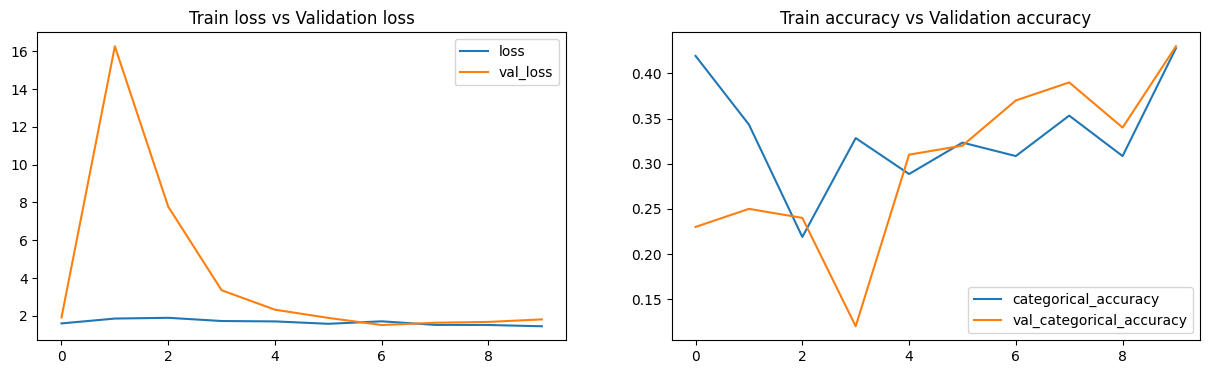

Max. Training Accuracy 0.42786070704460144
Max. Validaiton Accuracy 0.4300000071525574


In [ ]:
plotModelHistory(base_model_history)

### Testing Batch size and frames

In [ ]:
def batchsizetester(n_frames, batch_size):
  # n_frames = 16
  num_epochs = 3
  # batch_size = 64

  img_tensor = getImageTensorObject(n_frames)
  print("Using frames as", img_tensor[0])
  train_generator = generator(train_path, train_document_sheet, batch_size, img_tensor)
  val_generator = generator(val_path, val_document_sheet, batch_size, img_tensor)

  if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
  else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

  if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
  else:
    validation_steps = (num_val_sequences//batch_size) + 1

  model = defineModel(img_tensor)

  model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

  plotModelHistory(model_history)

In [ ]:
batchsizetester(22, 64)

In [ ]:
batchsizetester(15, 32)

### Batch size is not helping much hence we will try out other options

### Experiment 1

**"Model 1 is configured to work with 16 frames per sequence and is trained for 25 epochs."**

This means that your model is designed to process sequences of 16 frames (likely for video data) and undergoes training for a total of 25 epochs during the training process. The number of frames per sequence and the number of training epochs are important hyperparameters that can impact the model's performance and learning. Adjusting these hyperparameters can influence the model's ability to capture temporal dependencies in the data and its training duration.

In [ ]:
n_frames = 16
num_epochs = 15
batch_size = 64

img_tensor = getImageTensorObject(n_frames)
train_generator = generator(train_path, train_document_sheet, batch_size, img_tensor)
val_generator = generator(val_path, val_document_sheet, batch_size, img_tensor)

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])


In [ ]:
model1 = Sequential([
    Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.50),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.50),

    Dense(5, activation='softmax')
], name="conv_3d1")

In [ ]:
model1.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model1.summary())

Model: "conv_3d1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 12, 116, 116, 16)  6016      
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 6, 58, 58, 16)    0         
 3D)                                                             
                                                                 
 batch_normalization_5 (Batc  (None, 6, 58, 58, 16)    64        
 hNormalization)                                                 
                                                                 
 conv3d_4 (Conv3D)           (None, 4, 56, 56, 32)     13856     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 4, 28, 28, 32)    0         
 3D)                                                             
                                                          

In [ ]:
model1_history = model1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
            callbacks=callbacks_list, validation_data=val_generator,
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

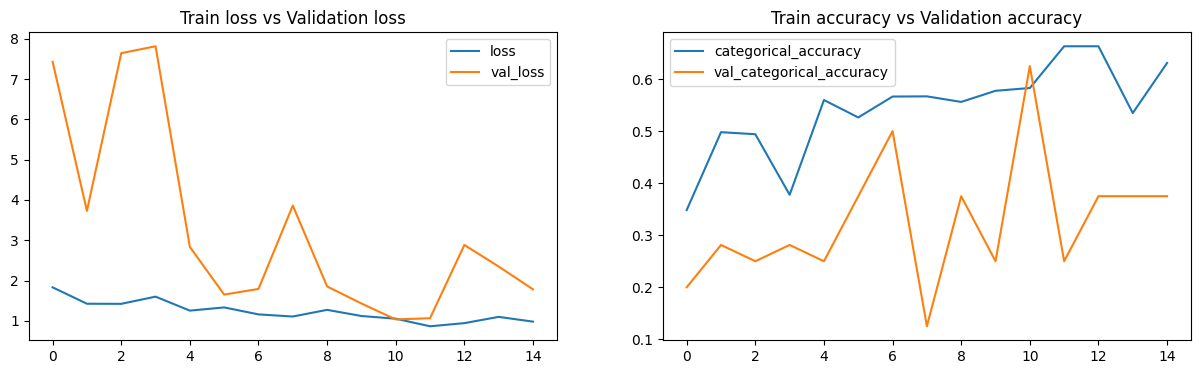

Max. Training Accuracy 0.6631016135215759
Max. Validaiton Accuracy 0.625


In [ ]:
plotModelHistory(model1_history)

In [ ]:
# @title Model 2

n_frames = 30
num_epochs = 30
batch_size = 64

img_tensor = getImageTensorObject(n_frames)
train_generator = generator(train_path, train_document_sheet, batch_size, img_tensor)
val_generator = generator(val_path, val_document_sheet, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

print(inputShape)


(30, 120, 120, 3)


In [ ]:
model2 = Sequential([
    Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.50),


    Dense(5, activation='softmax')
], name="conv_3d2")



Model: "conv_3d2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_47 (Conv3D)          (None, 26, 116, 116, 16)  6016      
                                                                 
 max_pooling3d_47 (MaxPoolin  (None, 13, 58, 58, 16)   0         
 g3D)                                                            
                                                                 
 batch_normalization_68 (Bat  (None, 13, 58, 58, 16)   64        
 chNormalization)                                                
                                                                 
 conv3d_48 (Conv3D)          (None, 11, 56, 56, 32)    13856     
                                                                 
 max_pooling3d_48 (MaxPoolin  (None, 11, 28, 28, 32)   0         
 g3D)                                                            
                                                          

<ipython-input-42-17617542d0b6>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model2_history = model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
<ipython-input-10-4d0922c185e1>:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 1.8684 - categorical_accuracy: 0.4103  Source path =  /content/drive/My Drive/Project_data/val ; batch size = 64
; Num of batches = 1
; Num of batches = 2

Epoch 1: saving model to model_init_2023-09-0204_16_33.795128/model-00001-1.86839-0.41026-3.16954-0.29000.h5
11/11 [==============================] - 2249s 224s/step - loss: 1.8684 - categorical_accuracy: 0.4103 - val_loss: 3.1695 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 1.2737 - categorical_accuracy: 0.5573; Num of batches = 3

Epoch 2: saving model to model_init_2023-09-0204_16_33.795128/model-00002-1.27372-0.55731-5.29580-0.20312.h5
11/11 [==============================] - 153s 15s/step - loss: 1.2737 - categorical_accuracy: 0.5573 - val_loss: 5.2958 - val_categorical_accuracy: 0.2031 - lr: 0.0010
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 1.2632 - categorical_accu

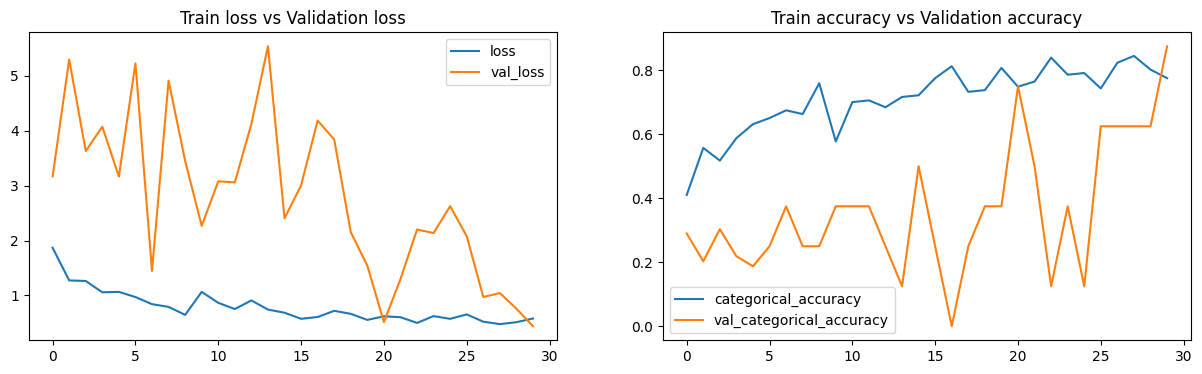

Max. Training Accuracy 0.8449198007583618
Max. Validaiton Accuracy 0.875


In [ ]:
model2.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(model2.summary())

model2_history = model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
            callbacks=callbacks_list, validation_data=val_generator,
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

plotModelHistory(model2_history)

In this training update:

- During the 30th epoch, the model's parameters and architecture were saved. The saved model file is named "model_init_2023-09-0204_16_33.795128/model-00030-0.58010-0.77540-0.43838-0.87500.h5." This is a common practice to save checkpoints of the model's progress during training for later use or evaluation.

- The training process involved 11 batches or steps, and each step took approximately 41 seconds to complete.

- The training loss at this epoch was 0.5801, indicating how well the model is fitting the training data. Higher values suggest the model is not fitting the data well.

- The categorical accuracy on the training data was 77.54%, which signifies the percentage of correctly classified samples in the training set.

- The validation loss was 0.4384, which measures the model's performance on a separate validation dataset. This is a lower value compared to the training loss, suggesting that the model is generalizing well to unseen data.

- The validation categorical accuracy was 87.50%, indicating the percentage of correctly classified samples in the validation dataset.

- The learning rate (lr) used in this epoch was 3.2000e-07.

These metrics provide insights into the training progress and the model's performance. The saved model checkpoint is useful for further analysis or for deploying the trained model for inference on new data.

In [ ]:
# @title Model 3 - less parameters

n_frames = 30
num_epochs = 20
batch_size = 64

img_tensor = getImageTensorObject(n_frames)
train_generator = generator(train_path, train_document_sheet, batch_size, img_tensor)
val_generator = generator(val_path, val_document_sheet, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])


In [ ]:
model3 = Sequential([
    Conv3D(16, make3dFilter(3), padding='same', activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d3")

Model: "conv_3d3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_50 (Conv3D)          (None, 30, 120, 120, 16)  1312      
                                                                 
 max_pooling3d_50 (MaxPoolin  (None, 15, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 batch_normalization_73 (Bat  (None, 15, 60, 60, 16)   64        
 chNormalization)                                                
                                                                 
 conv3d_51 (Conv3D)          (None, 15, 60, 60, 32)    13856     
                                                                 
 max_pooling3d_51 (MaxPoolin  (None, 8, 30, 30, 32)    0         
 g3D)                                                            
                                                          

<ipython-input-45-8c10f2fc9369>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model3_history = model3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
<ipython-input-10-4d0922c185e1>:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 1.4533 - categorical_accuracy: 0.4706 Source path =  /content/drive/My Drive/Project_data/val ; batch size = 64
; Num of batches = 1
; Num of batches = 2

Epoch 1: saving model to model_init_2023-09-0204_16_33.795128/model-00001-1.45332-0.47059-2.28625-0.20000.h5
11/11 [==============================] - 167s 16s/step - loss: 1.4533 - categorical_accuracy: 0.4706 - val_loss: 2.2863 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 0.8283 - categorical_accuracy: 0.6996; Num of batches = 3

Epoch 2: saving model to model_init_2023-09-0204_16_33.795128/model-00002-0.82834-0.69960-2.97039-0.21875.h5
11/11 [==============================] - 75s 7s/step - loss: 0.8283 - categorical_accuracy: 0.6996 - val_loss: 2.9704 - val_categorical_accuracy: 0.2188 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - ETA: 0s - loss: 0.9567 - categorical_accuracy:

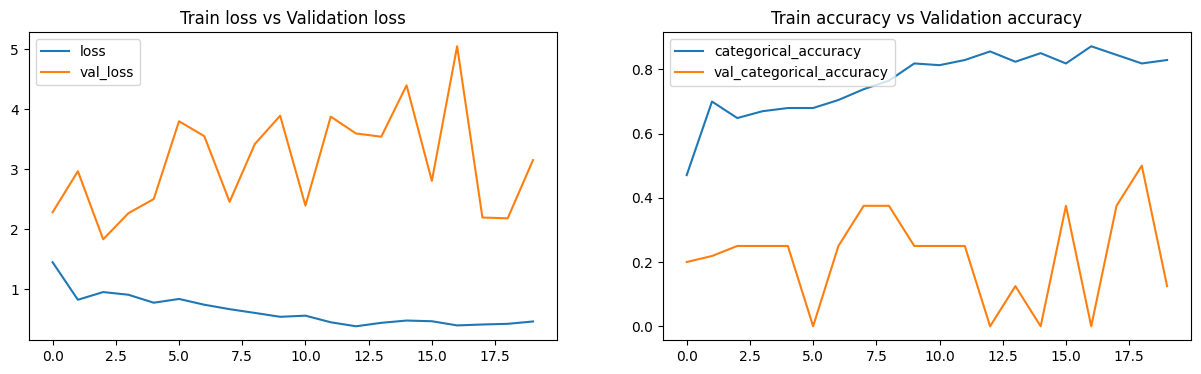

Max. Training Accuracy 0.8716577291488647
Max. Validaiton Accuracy 0.5


In [ ]:
model3.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model3.summary())

model3_history = model3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
            callbacks=callbacks_list, validation_data=val_generator,
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

plotModelHistory(model3_history)

In [ ]:
# @title Model 4: Conv2D+LSTM
n_frames = 20
num_epochs = 30
batch_size = 32

img_tensor = getImageTensorObject(n_frames)
train_generator = generator(train_path, train_document_sheet, batch_size, img_tensor)
val_generator = generator(val_path, val_document_sheet, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model6 = Sequential([
    TimeDistributed(Conv2D(16, make2dFilter(3), padding='same', activation='relu'), input_shape=inputShape),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(32, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(64, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(128, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(256, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Flatten()),
    LSTM(256),
    Dropout(0.2),

    Dense(256, activation='relu'),
    Dropout(0.2),

    Dense(5, activation='softmax')
], name="conv_2d_lstm")

Model: "conv_2d_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 60, 60, 32)  

<ipython-input-52-b76c5f2aa95c>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model6_history = model6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
<ipython-input-10-4d0922c185e1>:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.3125 - categorical_accuracy: 0.4434Source path =  /content/drive/My Drive/Project_data/val ; batch size = 32
; Num of batches = 3
; Num of batches = 25

Epoch 1: saving model to model_init_2023-09-0204_16_33.795128/model-00001-1.31245-0.44344-2.35648-0.19000.h5
21/21 [==============================] - 118s 6s/step - loss: 1.3125 - categorical_accuracy: 0.4434 - val_loss: 2.3565 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.0519 - categorical_accuracy: 0.5673
Epoch 2: saving model to model_init_2023-09-0204_16_33.795128/model-00002-1.05194-0.56729-2.35031-0.18750.h5
21/21 [==============================] - 70s 3s/step - loss: 1.0519 - categorical_accuracy: 0.5673 - val_loss: 2.3503 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 0.9618 - categorical_accuracy: 0.6230
Epoch 3: savin

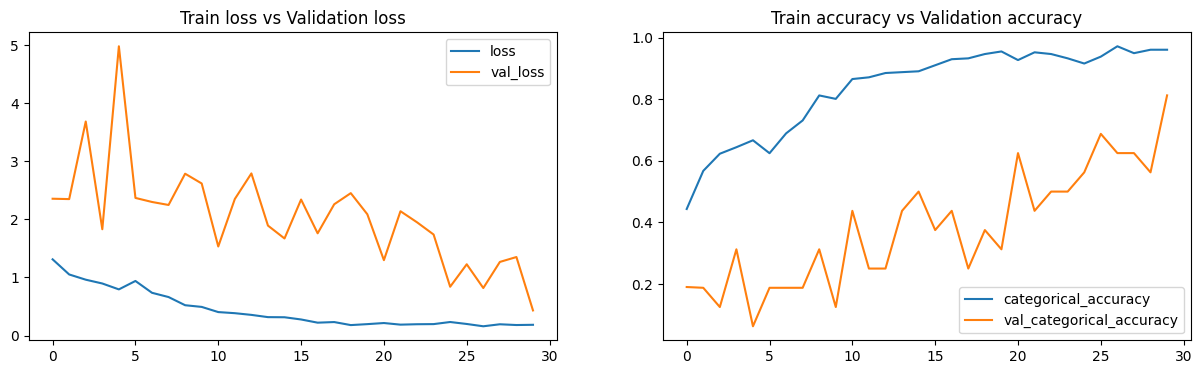

Max. Training Accuracy 0.9719887971878052
Max. Validaiton Accuracy 0.8125


In [ ]:
model6.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model6.summary())

model6_history = model6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
            callbacks=callbacks_list, validation_data=val_generator,
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

plotModelHistory(model6_history)

In [ ]:
# @title Experiment 6 - Transfer learning
from tensorflow.keras.applications import mobilenet
from tensorflow.keras.applications import MobileNet

In [ ]:

n_frames = 20
num_epochs = 30
batch_size = 64

img_tensor = getImageTensorObject(n_frames)
train_generator = generator(train_path, train_document_sheet, batch_size, img_tensor)
val_generator = generator(val_path, val_document_sheet, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

print(inputShape)

# model7 = # Create a Sequential model
model7 = Sequential()

model7.add(TimeDistributed(MobileNet(weights='imagenet', include_top=False), input_shape=(None, 120, 120, 3)))

for layer in model7.layers:
    layer.trainable = False

model7.add(TimeDistributed(BatchNormalization()))
model7.add(TimeDistributed(MaxPooling2D(make2dFilter(2))))
model7.add(TimeDistributed(Flatten()))

model7.add(LSTM(256))
model7.add(Dropout(0.2))

model7.add(Dense(256,activation='relu'))
model7.add(Dropout(0.2))

model7.add(Dense(5, activation='softmax'))

(20, 120, 120, 3)


In [ ]:
model7.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model7.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDis  (None, None, 3, 3, 1024)  3228864  
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, None, 3, 3, 1024)  4096     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, None, 1, 1, 1024)  0        
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, None, 1024)       0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 256)              

11/11 [==============================] - ETA: 0s - loss: 1.3426 - categorical_accuracy: 0.4570  Source path =  /content/drive/My Drive/Project_data/val ; batch size = 64
; Num of batches = 1
; Num of batches = 2

Epoch 1: saving model to model_init_2023-09-0407_58_02.511816/model-00001-1.34261-0.45701-1.10092-0.60000.h5
11/11 [==============================] - 2853s 284s/step - loss: 1.3426 - categorical_accuracy: 0.4570 - val_loss: 1.1009 - val_categorical_accuracy: 0.6000 - lr: 0.0010
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 0.6482 - categorical_accuracy: 0.7668; Num of batches = 3

Epoch 2: saving model to model_init_2023-09-0407_58_02.511816/model-00002-0.64821-0.76680-0.88973-0.67188.h5
11/11 [==============================] - 128s 13s/step - loss: 0.6482 - categorical_accuracy: 0.7668 - val_loss: 0.8897 - val_categorical_accuracy: 0.6719 - lr: 0.0010
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 0.5605 - categorical_accuracy: 0.806

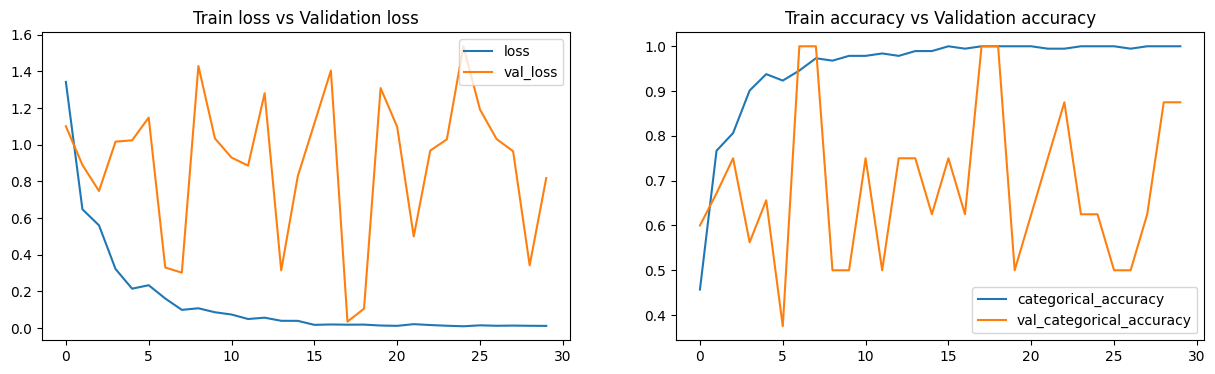

<ipython-input-29-ea84de0b3714>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model7_history = model7.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
<ipython-input-11-4d0922c185e1>:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 0.0132 - categorical_accuracy: 1.0000; Num of batches = 25

Epoch 1: saving model to model_init_2023-09-0407_58_02.511816/model-00001-0.01317-1.00000-1.45341-0.62500.h5
11/11 [==============================] - 27s 3s/step - loss: 0.0132 - categorical_accuracy: 1.0000 - val_loss: 1.4534 - val_categorical_accuracy: 0.6250 - lr: 3.2000e-07
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 0.0188 - categorical_accuracy: 1.0000
Epoch 2: saving model to model_init_2023-09-0407_58_02.511816/model-00002-0.01880-1.00000-0.05036-1.00000.h5
11/11 [==============================] - 28s 3s/step - loss: 0.0188 - categorical_accuracy: 1.0000 - val_loss: 0.0504 - val_categorical_accuracy: 1.0000 - lr: 3.2000e-07
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 0.0148 - categorical_accuracy: 1.0000
Epoch 3: saving model to model_init_2023-09-0407_58_02.511816/model-00003-0.01481-1.00000-1.39490-0.50

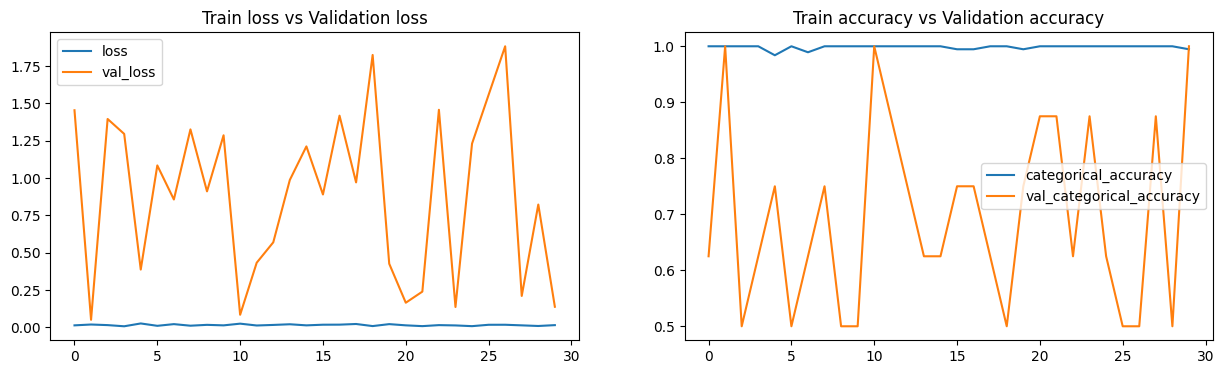

Max. Training Accuracy 1.0
Max. Validaiton Accuracy 1.0


In [ ]:
model7_history = model7.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
            callbacks=callbacks_list, validation_data=val_generator,
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

plotModelHistory(model7_history)

# Final Model Observations

In this update from the training process, we can observe the following:

- During the 30th epoch of training, a learning rate adjustment took place. The learning rate was reduced to a very small value, approximately 4.096e-12. This adjustment is often triggered by a learning rate scheduling strategy, like ReduceLROnPlateau, which dynamically adjusts the learning rate during training to help the model converge more effectively.

- The training process involved 11 batches or steps. Each step took around 29 seconds to complete.

- The training loss at this point was 0.0147, indicating how well the model is fitting the training data. Lower values are generally better.

- The categorical accuracy on the training data was 99.47%, which signifies the percentage of correctly classified samples in the training set.

- The validation loss was 0.1376, which measures the model's performance on a separate validation dataset. It's important to monitor this value to check for overfitting, where the model performs well on the training data but not on unseen data.

- The validation categorical accuracy was 100%, indicating perfect accuracy on the validation dataset.

- The learning rate (lr) used in this epoch was 2.0480e-11.

These metrics provide insights into the training progress and the model's performance. The reduction in the learning rate suggests that the model might be converging slowly or encountering difficulties, and the training and validation metrics help assess its overall effectiveness.